In [25]:
%matplotlib inline
import numpy as np
from matplotlib import pylab as plt
np.set_printoptions(suppress=True, precision = 3)
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score, calinski_harabasz_score

##Principal Component Analysis (PCA)

PCA is a linear dimensionality reduction technique that can be utilized for extracting information from a high-dimensional space by projecting it into a lower-dimensional sub-space.

###Reduce dimension for MNIST data

In [2]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
x,y = load_digits(return_X_y=True)
print('Input X shape:',x.shape)

Input X shape: (1797, 64)


In [3]:
# For visualization, we just use first 2 components.
pca = PCA(n_components=2)
pca.fit(x)
z = pca.transform(x)

In [4]:
# Visualize the clustering
def plot_digit(x, y, title=None):

    # Normalize the input for better illustration
    x_min, x_max = np.min(x, axis=0), np.max(x, axis=0)
    x = (x- x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for i in range(x.shape[0]):
        plt.text(x[i, 0], x[i, 1], str(y[i]),
                 color=plt.cm.nipy_spectral(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if title is not None:
        plt.title(title, size=17)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    # remove the spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.tight_layout()

# Modified from https://scikit-learn.org/stable/auto_examples/cluster/plot_digits_linkage.html#sphx-glr-auto-examples-cluster-plot-digits-linkage-py

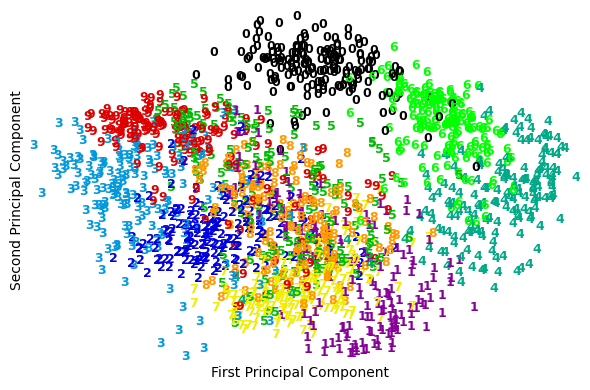

In [5]:
plot_digit(z,y)

In [7]:
%%time
# Fit the SVM classifier on the original data set
clf = SVC(kernel='rbf',gamma='scale')
clf.fit(x,y)
print('Training Acc:',accuracy_score(y,clf.predict(x)))

Training Acc: 0.996661101836394
CPU times: user 308 ms, sys: 737 µs, total: 309 ms
Wall time: 519 ms


In [8]:
# For SVM classification, we use 10 components
pca = PCA(n_components=10)
z = pca.fit_transform(x)

In [9]:
%%time
# Fit the SVM classifier on the reduced data z
clf = SVC(kernel='rbf',gamma='scale')
clf.fit(z,y)
print('Training Acc:',accuracy_score(y,clf.predict(z)))

Training Acc: 0.991652754590985
CPU times: user 218 ms, sys: 0 ns, total: 218 ms
Wall time: 251 ms


##Clustering

### Partition-based clustering: K-Means Clustering

The standard K-Means algorithm has the following three steps:

1.  Initialization: Randomly choose K observations from the data set and use them as the initial means(cneters);

2.  Assignment step: Assign each observation to the cluster whose mean has the least squared Euclidean distance (Note other kinds of distance measues can also be applied here);

3.  Update step: Calculate the center of each new cluster.

The results of the K-means clustering algorithm are:

-  The centers of the K clusters;

-  Labels for the training data (each data point is assigned to a single cluster).

K-means++ variant:
Randomly select the 1st initial center. With n initial centers selected, sample with longer distances to the previous n centers will have higher probability to be selected as the n+1 center.

In [11]:
#Load iris data
iris = load_iris()
X = iris.data
y = iris.target
scaler_x = MinMaxScaler((-1, 1))
sX = scaler_x.fit_transform(X)

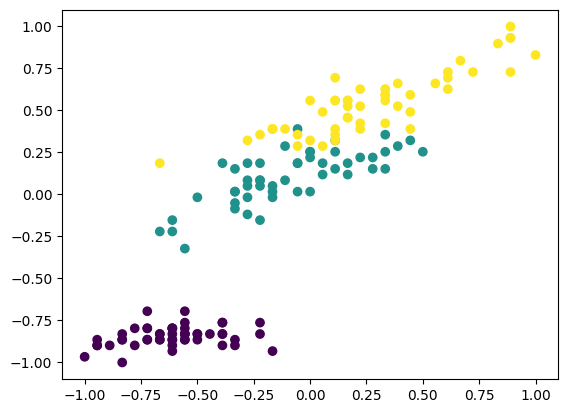

In [12]:
# Plot the scatter plot with the normalized first and third feature in the dataset
x = sX[:, [0, 2]]
plt.scatter(x[:, 0], x[:, 1], c=y)
plt.show()

In [14]:
def plot_decision_boundary(x, y, model, title):

    h = 0.02
    x_min, x_max = x[:, 0].min()-0.1, x[:, 0].max() +0.1
    y_min, y_max = x[:, 1].min()-0.1, x[:, 1].max() +0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point(corner) in mesh. Use last trained model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.scatter(x[:, 0:1], x[:, 1:2], c=y, edgecolors='k')
    plt.title(title, fontsize = 20)

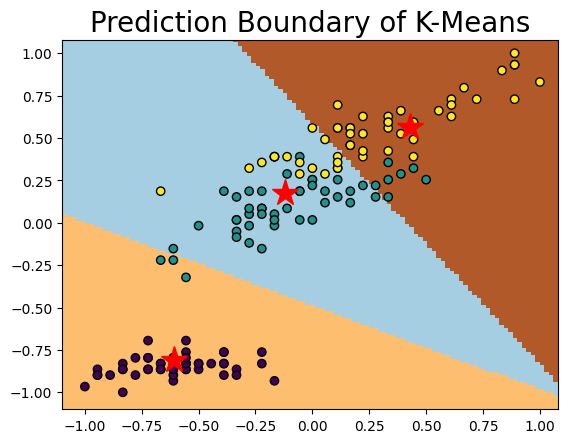

In [16]:
kmean1 = KMeans(n_clusters=3, init='random', random_state=42)
kmean1.fit(x)
plot_decision_boundary(x, y.reshape([-1, 1]), kmean1, "Prediction Boundary of K-Means")
# Plot a star for each center
plt.plot(kmean1.cluster_centers_[:, 0], kmean1.cluster_centers_[:, 1], '*', markersize=20, color="red")

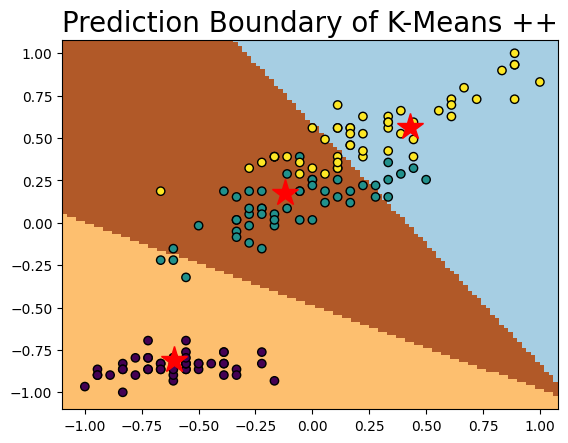

In [17]:
kmean2 = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmean2.fit(x)
plot_decision_boundary(x, y.reshape([-1, 1]), kmean2, "Prediction Boundary of K-Means ++")
plt.plot(kmean2.cluster_centers_[:, 0], kmean2.cluster_centers_[:,1], '*', markersize=20, color="red")

### Hierarchical density-based clustering: Agglomerative Clustering

In contrast with K-means, hierarchical clustering splits or merges the samples successively to construct the clusters.

-  For the splitting case (top-down), the algorithm starts from the whole data set with size n and then hierarchically divides the data into two or more distinctive subsets in terms of certain criteria until the cluster number becomes n.
-  In opposite, the merging or agglomerative clustering (bottom-up) starts from n data points/clusters and iteratively merges similar clusters until all clusters are merged together. In this section, we only consider the agglomerative algorithm.

The agglomerative hierarchical clustering works as follows:

1. Specify a distance metric d(⋅,⋅) between two samples and a criterion D(⋅,⋅) (or linkage) to measure the similarity between two clusters. Note that linkage is based on the distance metric d.

2. Let each sample be a distinctive cluster.

3. Iteratively find and merge two most similar clusters with smallest D until there only exists one cluster.

There exist many approaches to measure the distance of two clusters:

- Ward linkage clustering: Minimize the variance of the clusters being merged;

- Complete linkage clustering: Find the maximum possible distance between points belonging to two different clusters;

- Single linkage clustering: Find the minimum possible distance between points belonging to two different clusters;

- Mean linkage clustering: Find all possible pairwise distances for points belonging to two different clusters and then calculate the average.

In [19]:
def plot_dendrogram(model, **kwargs):
    children = model.children_
    distance = np.arange(children.shape[0])
    no_of_observations = np.ones((children.shape[0]))
    no_of_observations = no_of_observations * 2
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
    sch.dendrogram(linkage_matrix, **kwargs)

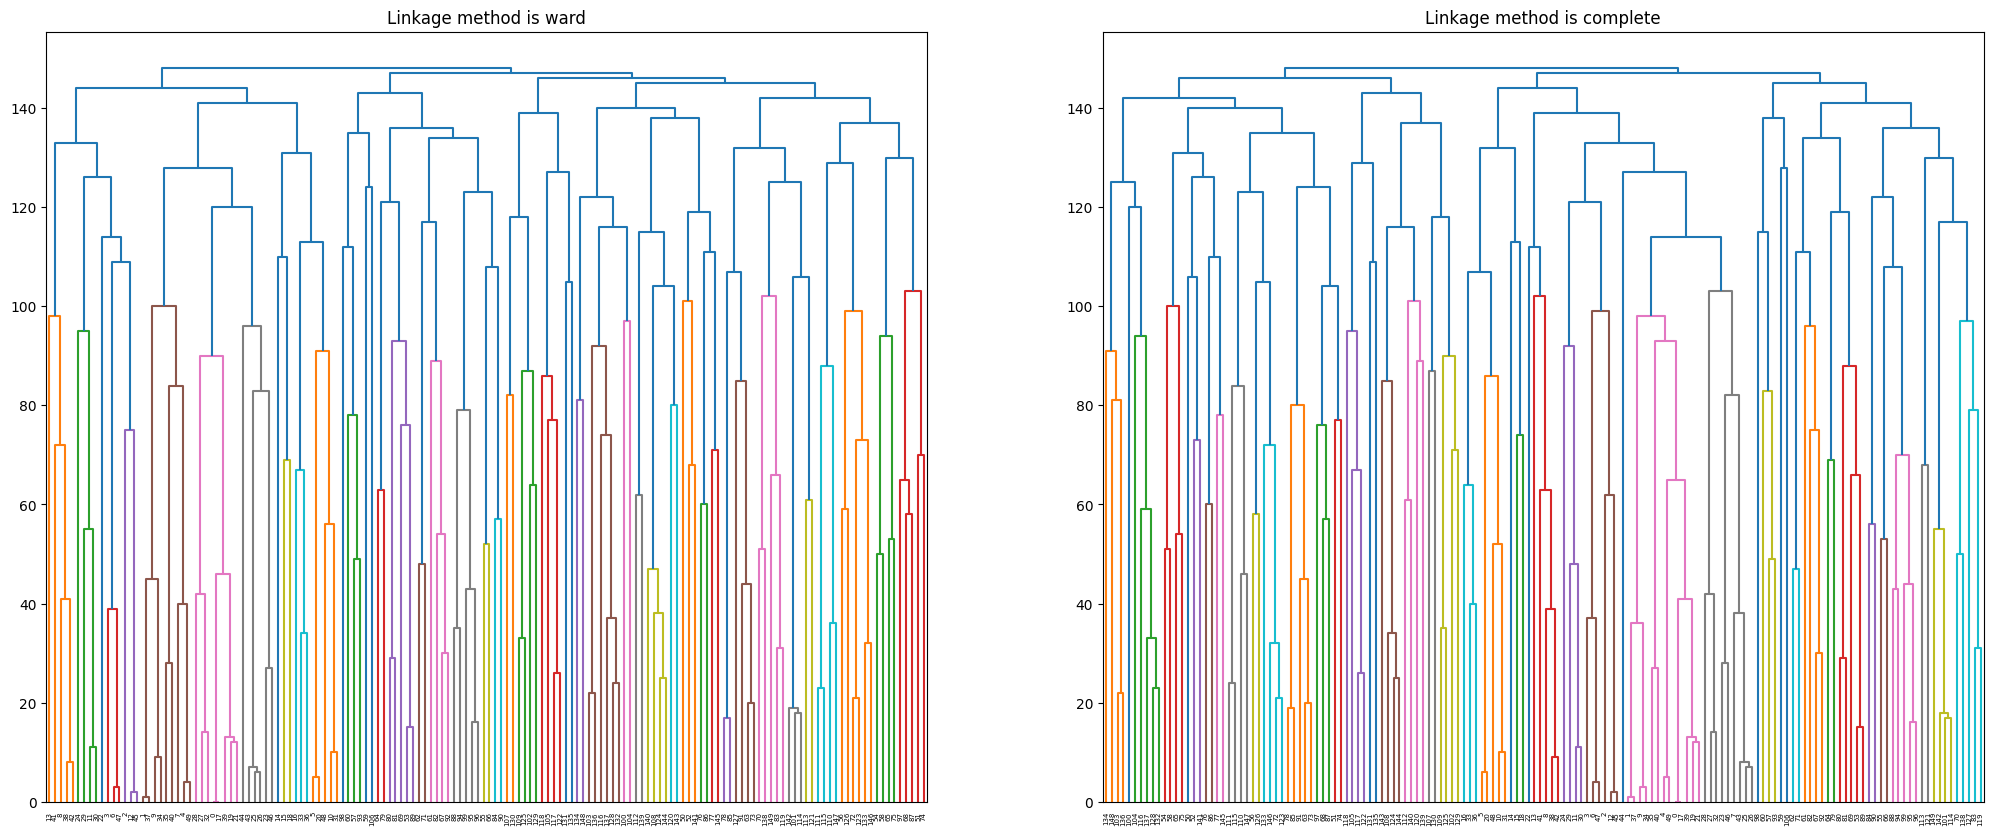

In [20]:
H_C_ward = AgglomerativeClustering(n_clusters=3) # default linkage is ward.
H_C_complete = AgglomerativeClustering(n_clusters=3, linkage='complete')

pred_hc_ward = H_C_ward.fit_predict(x)
pred_hc_complete = H_C_complete.fit_predict(x)

fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(1, 2, 1)
plot_dendrogram(H_C_ward)
ax.set_title('Linkage method is ward')

ax = fig.add_subplot(1, 2, 2)
Z2 = plot_dendrogram(H_C_complete)
ax.set_title('Linkage method is complete')
plt.show()

Text(0.5, 1.0, 'True Labels')

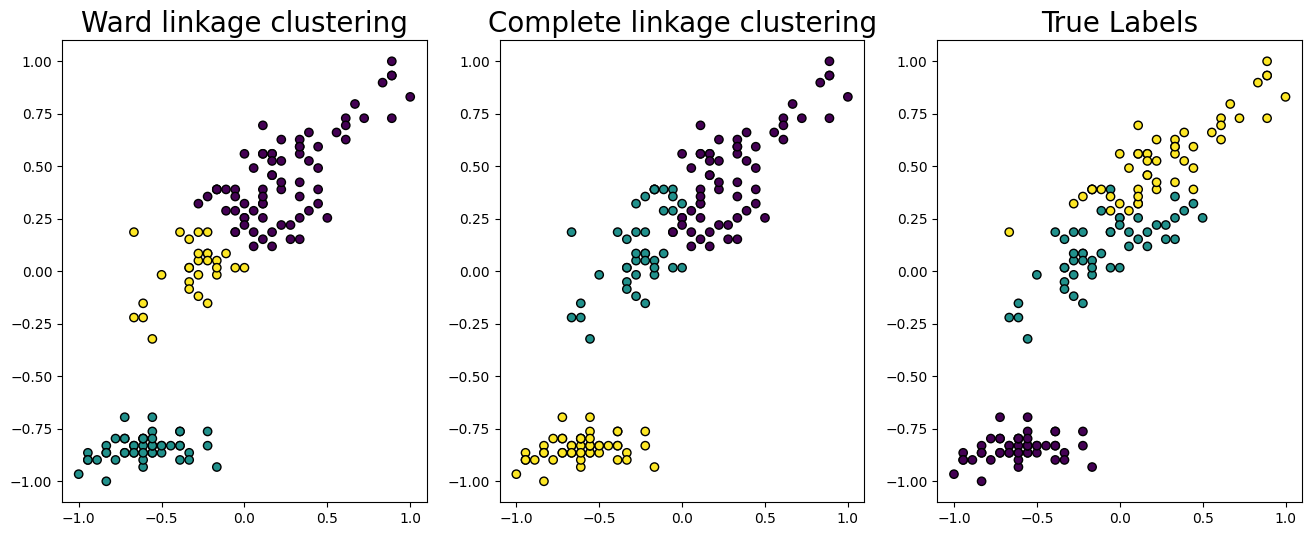

In [21]:
f = plt.figure(figsize = (16, 6))
ax = f.add_subplot(1, 3, 1)
ax.scatter(x[:, 0:1], x[:, 1:2], c=pred_hc_ward.reshape([-1, 1]), edgecolors='k')
ax.set_title("Ward linkage clustering", fontsize=20)
ax = f.add_subplot(1, 3, 2)
ax.scatter(x[:, 0:1], x[:, 1:2], c=pred_hc_complete.reshape([-1, 1]), edgecolors='k')
ax.set_title("Complete linkage clustering", fontsize=20)
ax = f.add_subplot(1, 3, 3)
ax.scatter(x[:, 0:1], x[:, 1:2], c=y.reshape([-1, 1]), edgecolors='k')
ax.set_title("True Labels", fontsize=20)

###Clustering Performance Evaluation

External Measures: measure similarity of clustering against known class labels.
-  Entropy (The smaller, the better)
-  Rand index (The larger, the better)

Internal Measurements:
-  Silhouette coefficient (The larger, the better)
-  Ratio of between-cluster dispersion to within-cluster dispersion (The larger, the better)

In [22]:
#Entropy
from sklearn.metrics import jaccard_score, adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix
def get_entropy(y, pred, n_class):
    p = np.zeros((n_class, n_class))
    tb = contingency_matrix(y, pred)
    for i in range(n_class):
        for j in range(n_class):
            p[i, j] = tb[i, j]/np.sum(tb[i, :])
    E = np.zeros((3, 1))
    for i in range(n_class):
        for j in range(n_class):
            if (p[i, j] != 0):
                E[i] = E[i] - p[i, j] * np.log(p[i, j])
    Entropy = np.dot(np.sum(tb, 1) / np.sum(tb), E)
    return Entropy

In [23]:
pred1 = kmean1.fit_predict(x)
pred2 = H_C_complete.fit_predict(x)
print("Entropy:", np.round(get_entropy(y, pred1, 3)[0], 3),
                  np.round(get_entropy(y, pred2, 3)[0], 3), )
print("Adjusted Rand Index:", np.round(adjusted_rand_score(y, pred1), 3),
                              np.round(adjusted_rand_score(y, pred2), 3), )

Entropy: 0.416 0.394
Adjusted Rand Index: 0.598 0.57


In [26]:
print("Silhouette Coefficient:", np.round(silhouette_score(x, pred1), 3),
                  np.round(silhouette_score(x, pred2), 3), )
print("Ratio of between-cluster dispersion to within-cluster dispersion:",
                              np.round(calinski_harabasz_score(x, pred1), 3),
                              np.round(calinski_harabasz_score(x, pred2), 3), )

Silhouette Coefficient: 0.553 0.523
Ratio of between-cluster dispersion to within-cluster dispersion: 498.025 439.969
